In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu126
12.6


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.9.0+cu126
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-e1ezop6b
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-e1ezop6b
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 44dee49ad88cf5253e8092cfce3e453c00bc8c3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Install required packages.
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# 1. Introduction

In [ ]:
import os
import torch

# Helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Intro: Hands-on Graph Neural Networks
- GNNs aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.
- This is done by following a simple neural message passing schema, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:
$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$
- A simple graph structured example, Zachary's karate club network, this graph describes a social network of 34 members of a karate clud and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.
- PyTorach geometric provides an easy access to this data via the torch_geometric.datasets

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [ ]:
print(f"Dataset: {dataset}")
print("===============================")
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


- After analyzing the Karateclub dataset, we 1st can inspect some of its properties. For example, we can see that this dataset holds exactly one graph, and that node in this dataset is assigned a 34-dimensional feature vector (which uniquely describes the members of the karate club). Furthermore, the graph hold exactly 4 classes, which represent the community each node belongs to

In [ ]:
data = dataset[0]
print(data)
print("============================")

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


- Each graph in PyTorch Geometric is represented by a single Data object, which holds all the information to describe its graphs representation. We can print the data object anytime via print(data) to receive a short summary about its attributes and their shapes:

In [ ]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

- We can see that this data object holds 4 attributes:
    1. edge_index: Information about the graph connectivity, i.e., a tuple of source and destination node indices for eachh edges.
    2. node features as x (each of the 34 nodes is assigned a 34-dim feature vector)
    3. node labels as y (each node is assigned to exactly one class)
    4. train_mask: describes for which nodes we already known their communicty assignments.  In total, we only aware of the ground truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remanining nodes.

In [ ]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

- By printing edge_index, we can understand how PyG represents graph connectivity internally. We can see that for each edge, edge_index holds a typle of 2 node indices, where the 1st value describes the node index of the source node and the 2nd value describes the node index of the destination node of an edge.
- This representation is known as the COO format (coordinate format) commonly used for representing sparse matrices.  Instead of holding the adjacency information in a dense representation. PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in  A  are non-zero.
- In directed graphs reverse edges exist for every entry in edge_index.

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
# visualize_graph(G, color=data.y)

## Implementing GNN
- We will use on of the most simple GNN operators, the GCN layer, which is defined as
$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$
- where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
- PyG implement this layer via GCNConv, which can be executed by passing in the node feature representation x and the COO graph connectivity representation `edge_index`.

In [ ]:
from torch import nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifer = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier
        out = self.classifer(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifer): Linear(in_features=2, out_features=4, bias=True)
)


- Here, we 1st initalize all of our building blocks in `__init__` and define the computation flow of our network in `forward`. We 1st define and stack 3 GCN layers, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 hops away). In addition the `GCNConv` layers reduce the feature dimensionality to 2, i.e., 34->4->4->2. Each `GCNConv` layer is enchanced by a tanh non-linearity.
- After that, we app,y a single linear transformation (torch.nn.Linear) that acts as a classifier to map our nodes to 1 out of 4 classes/communities.
- We return both the output of the final classifier as well as the final node embeddings produced by out GNN. We proceed to initialize our final model via GCN(), and printing our model produces a summary of all its used sub-modules.

## Embedding the Karate Club Network
- Let's take a look at the node embeddings produced by our GNN. Here, we pass in the initial node features x and the graph connectivity information edge_index to the model, and visualize its 2-dimensional embedding.

In [ ]:
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

Embedding shape: [34, 2]


- Even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph. Nodes of the same color (community) are already closely clustered together in th embedding space, although the weights of our model are initialized completely at random and we have not yet performed any training so far! This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.
## Training on the Karate Club network
- Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):
- Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react. Here, we make use of a semi-supervised or transductive learning procedure: We simply train aganist one node per class, but are allowed to make use of the complete input graph data.
- Training our model is very similar to any other PyTorch model. We definea loss critertion and initialize a stochastic gradient optimizer. Afer that, we perform mulitple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t to the loss derived from the forward pass.

In [ ]:
import time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# Node Classification

In [ ]:
# Optimized scatter and segment reduction operations
# !pip install torch-scatter
# # extension for sparse matrix operations, including optimized spare tensors, sparse matmul, and adjacency operations
# !pip install torch-sparse
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
^C


In [ ]:
import os
import torch

# Helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Node Classification with Graph Neural Networks
- To apply GNNs to the task of node classification. Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remanining nodes (transductive learning).
- To demonstrate, we make use of `Cora` dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exist a citation link betweem them. The task is to infer the category of each document (7 in total).

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [ ]:
print(f'Dataset: {dataset}')
print('=========================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [ ]:
data = dataset[0] # Get the 1st graph object

# Gather statistics about the graph
print(data)
print('=========================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

- wWe can see that the `Cora` network holds 2708 nodes and 10,556 edges, resulting in an average node degree of 3.9. For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class). This results in node label rate of only 5%
- In contrast to `KarateClub` this graph holds the additional attributes val_mask and test_mask, which denotes which nodes should be valdiation and testing. Furthermore, we make use of data transformation via transform=NormalizeFeatures(). Transforms can be used to modify our input data before inputtng them into a neural network, e.g., for normalization or data augmentation. Here, we row-normalze the bag-of-words input feature vectors.
- We can further see that this network is undirected, and that there exists no isolated nodes (each document has atleast one citation).

### Training a Multi-layer Perception Network (MLP)
- In theory, we should be able to infer the category of a document solely based on its content, i.e. its bag-of-words feature representation, without taking any relational information into account.

In [ ]:
import torch
from torch import nn
from torch.nn import Linear
from torch.nn import functional as F
from torch.optim import Adam

class MLP(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

- Our MLP is defined by 2 linear layers and enched by ReLU non-Linearity and dropout.
- Here, we 1st reduce the 1433 dimensional feature vector to a low-dimensional embedding (hidden_channels=16), while the 2nd linear leayer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.
- We will use the corss entropy loss and Adam optimizer.
- This time, we also define a test function to evalute how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
model = MLP(hidden_channels=16)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
data.x, data.x.shape

In [ ]:
data.train_mask, data.train_mask.shape

In [ ]:
data.y, data.y.shape

In [ ]:
def train():
  model.train()
  optimizer.zero_grad() # Clear gradients
  out = model(data.x) # Perform a single forward pass.
  print(out.shape)
  loss = criterion(out[data.train_mask], data.y[data.train_mask]) # compute the loss solely based on the training node
  loss.backward() # Derive gradients
  optimizer.step() # Update parameters based on gradients
  return loss

In [ ]:
def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1) # Use the class with highest probability
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # Check aganist ground-truth labels
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) # Derive ratio of correct predictions
  return test_acc

In [ ]:
for epoch in range(1, 201):
  loss = train()
  print(f'Epoch: {epoch: 03d}, Loss: {loss:.4f}')

- After training the model, we can call the test function to see how well our model performs on unseen labels. We interestd in the accuracy of the model, i.e., the ratio of correctly classified nodes.

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

- MLP performs rather bad with only 59% test accuracy. But why does the MLP do not perform better? The main reason for that is that this model suffers from heavy overfitting due to only having access to a small amount of training nodes, and therefore generalizes poorly to unseen node representations.
- It also fails to incorporate an important bias into the model: Cited papers are very likely related to the category of a document.


## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels=16)
print(model)

- Let's visualize the node embeddings of our untrained GCN netwok. For visualization, we make use of TSNE to embed our 7-dimensional node embeddings onto a 2D plane.

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

- We centrainly can do better by training our model. The training and testing procedure is once again the same, but this time we make use of the node features x and the graph connectivity edge_index as input to our GCN model

In [ ]:
model = GCN(hidden_channels=16)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train():
  model.train()
  optimizer.zero_grad() # Clear gradients
  out = model(data.x, data.edge_index) # Perform a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss


In [ ]:
def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

In [ ]:
for epoch in range(1, 101):
  loss = train()
  print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

- After training the model, we can check its test accuracy.

In [ ]:
test_acc = test()
print(f'test accuracy: {test_acc:.4f}')

- By simply swapping the linear layers with GNN layers, we can reach 81.5% of test accuracy! This is in stark contrat on the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.
- We can also verify that once again by looking at the output embeddings of our trained model, hich now produces a fat better clustering of nodes of the same category.

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Exercises
1. To achive better model performance and to avoid overfitting,it is usally a good idea to select the best model based on an additional validation set. The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet. Can we modify the code to select and test the model with the highest validation performance.
2. How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?
3. We can try use different GNN layers to see how model performance changes. What happens if we swap out all GCNConv instance with GATConv layers that make use of attention? Let's try to write a 2-layer GAT model that makes use of 8 attention heads in the 1st layer and 1 attention head in the 2nd layer, uses a dropout ratiro of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head

In [ ]:
from torch_geometric.nn import GATConv

In [ ]:
class GAT(nn.Module):
  def __init__(self, hidden_channels, heads):
     super().__init__()
     torch.manual_seed(1234567)
     self.conv1 = GATConv(in_channels=dataset.num_features, out_channels=hidden_channels, heads=heads) # 8 attention heads
     self.conv2 = GATConv(in_channels=hidden_channels*heads,out_channels=dataset.num_classes, heads=1) # 1 attentiohead

  def forward(self, x, edge_index):
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv1(x, edge_index)
    x = F.elu(x)
    x = F.dropout(x, p=0.6, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GAT(hidden_channels=8, heads=8)
print(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

In [ ]:


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Graph Classification
- GNNs to the task of graph classification. Graph classification refers to the problem of classifying entire graphs (in constrast to nodes), given a dataset of graphs, based on some structural graph properties. Here, we want to embed entire graphs, and we want to embed thoese graphs in such a way so that they are linearly separable given a task at hand.
- 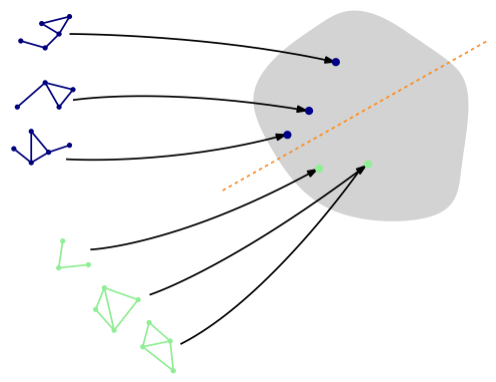

- The most common task for graph classification is molecular property prediction, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.
- The TU Dortmund university has collected a wide range of different graph classification datasets, known as the TUDatasets, which are also accessible via PyTorch.

In [ ]:
import torch
from torch_geometric.datasets import TUDataset

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

In [ ]:
print(f'Dataset: {dataset}')
print('===========================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [ ]:
data = dataset[0]

In [ ]:
print()
print(data)
print('=============================================================')
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

- This dataset provides 188 different graphs, and the task is to classify each graph into one out of 2 classes.
- By inspecting the 1st graph object of the dataset, we can see that it comes with 17 nodes (with 7-dimensional feature vectors) and 38 edges (leading to an average node degree of 2.24). It also comes with exactly one graph label (y=[1]), and, in addition to previous datasets, provides additional 4-dimensional edge features (edge_attr=[38, 4]). However, for the sake of simplicity, we will make use of those.
- PyTorch Geometric provdies some useful utilities for working with graph datasets, e.g., we can shuffle the dataset and use the 1st 150 graphs as training graphs, while using the remaning ones for testing:

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

## Mini-batching of graphs
- since graphs in graph classification datasets are usually small, a good idea is to batch the graphs before inputting them into GNN to guarantee full GPU utilization.
- In image or language domain, this procedure is typically achieved by rescaling or padding each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension. The length of this dimension is then equal to the number of examples grouped in a min-batch and is typically referred to as the batch_size.
- However, for GNNs the 2 approaches described above are either not feasiable or many result in a lot of unncessary memory consumption. Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples.
- Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target are simply concatenated in the node dimension:
- 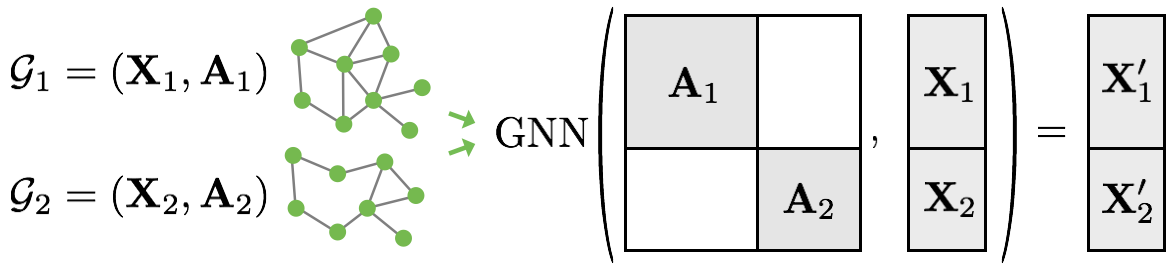
- This procedure has some advantages over othe batching procedures:
  1. GNN operators that rely on a message passing scheme do not need to modifed since messages are not exchanged between 2 nodes that belong to different graphs.
  2. There is no computational or memory overhead since adjacney matrices are saved in a sparse fashion holding only non-zero entries, i.e., the edges.
- PyTorch Geometric automatically takes care of batching multiple graphs into a single gaint graph with the help of data.DataLoader class

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

- Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) min-batches, containing all 150 graphs
- Furthermore, each Batch object is equipped with batch vector, which maps each node to its respctive graph in the batch

### Training a GNN
- Training a GNN for graph classification usually follows a simple recipe:
  1. Embed each node by performing multiple rounds of message passing.
  2. Aggregate node embeddings into a unified graph embedding (readout layer)
- There exists multiple readout layers in literature,
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$
- Provides this functionality via `torch_gemetric.nn.global_mean_pool`, which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.
-


In [ ]:
dataset.num_node_features, dataset.num_classes

In [ ]:
from torch.nn import Linear
from torch.nn import functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [ ]:
class GCN(nn.Module):
  def __init__(self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(12345)
    self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)
    self.lin = Linear(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index, batch):
    # 1. Obtain node embeddings
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    x = x.relu()
    x = self.conv3(x, edge_index)

    # 2. Readout layer
    x = global_mean_pool(x, batch) # [batch_size, hidden_channels]

    # 3. Apply a final classifier
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin(x)

    return x

model = GCN(hidden_channels=64)
print(model)

In [ ]:
model = GCN(hidden_channels=64)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train():
  model.train()

  for data in train_loader:# Iterate in batches over the training dataset
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out, data.y) # Compute the loss
    loss.backward() # Derive gradients
    optimizer.step() # Update parameters based on gradients
    optimizer.zero_grad() # Clear gradients


In [ ]:
def test(loader):
  model.eval()
  correct = 0
  for data in loader: # Iterate in batches over the training/test dataset
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1) # Use the class with higest probability
    correct += int((pred == data.y).sum()) # Check aganist ground-truth labels
  return correct / len(loader.dataset) # Derive ratio of correct predictions

In [ ]:
for epoch in range(1, 171):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

- Our model around 75% test accuracy. Reason for the flucations in accuracy cab be explained by the rather small dataset (only 38 test graphs), and usually disappear once one applies GNNs to larger datasets

## Exercise:
- Applying neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures. An alternative formulation omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central ndoe information.

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$
- This layer is implemented under the name GraphConv in PyTorch Geometric

In [ ]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(in_channels=dataset.num_node_features, out_channels=hidden_channels)
        self.conv2 = GraphConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv3 = GraphConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

In [ ]:
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Scaing Graph Neural Networks
- We have trained Graph Neural Networks for node classification tasks solely in a full-batch fashion. In particular, that means that every node's hidden representation was computed parallel and was available for re-use in the next layer.
- However, once we want to operate on bigger graphs, this scheme is no longer feasible since memory consumption explodes. For example, a graph with around 10 million nodes and a hidden feature dimensionality of 128 already consumes about 5GB of GPU memory for each layer.
- There has recently been some effort to let GNN scale to bigger graphs. Once of those approahces is known as Cluster-GCN, which is based on pre-partitioning the graph into subgraphs on which one can operate in a min-batch fashion.
- Let's load the `PubMed` graph from the `Planetoid` node classification benchmark.

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


In [ ]:
data = dataset[0]  # Get the first graph object.

In [ ]:
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

- This graph has around 19,717 nodes. While this number of nodes should fit into GPU memory with ease, it's nonetheless a good example to showcase how one scale GNNs up within PyTorch Geometric
- Cluster-GCN, works by first partioning the graph into subgraphs based on graph paritioning algorithms. With this, GNNs are restricted to solely convolve inside their specific subgraphs, which omits the problem of neighborhood explosion.
- 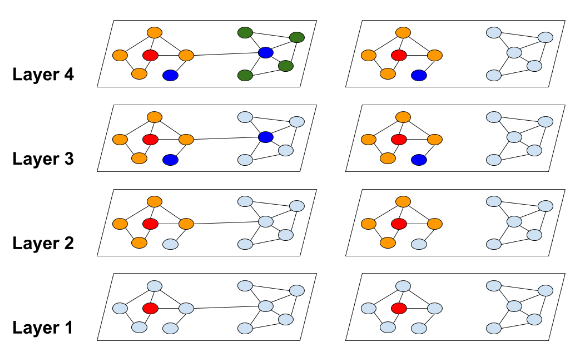
- However, after the graph is paritioned, some links are removed which may limit the model's performance due to a biased estimation. To address this issue, Cluster-GCN also incorporates between-cluster links inside a mini-batch which results in the following stochastic parititioning scheme:
- 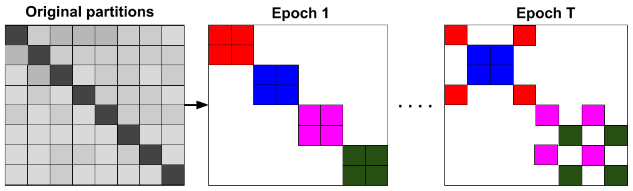

- Here, color represent the adjacency information that is maintained per batch (which is potentially different for every epoch).
_ PyTorch Gemetric provides a 2-stage implementation of the cluster-GCN algorithm:
  1. ClusterData converts a `Data` object into a dataset of subgraphs containing num_parts partitions.
  2. Given a user-defined `batch_size`, ClusterLoader implements the stochastic paritioning scheme in order to create min-batches
  - The procedure to craft mini-batches then looks as follows:

In [ ]:
from torch_geometric.loader import ClusterData, ClusterLoader

In [ ]:
torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...
Done!

Step 1:
=======
Number of nodes in the current batch: 4930
Data(x=[4930, 500], y=[4930], train_mask=[4930], val_mask=[4930], test_mask=[4930], edge_index=[2, 16814])

Step 2:
=======
Number of nodes in the current batch: 4930
Data(x=[4930, 500], y=[4930], train_mask=[4930], val_mask=[4930], test_mask=[4930], edge_index=[2, 16810])

Step 3:
=======
Number of nodes in the current batch: 4937
Data(x=[4937, 500], y=[4937], train_mask=[4937], val_mask=[4937], test_mask=[4937], edge_index=[2, 16996])

Step 4:
=======
Number of nodes in the current batch: 4920
Data(x=[4920, 500], y=[4920], train_mask=[4920], val_mask=[4920], test_mask=[4920], edge_index=[2, 16086])

Iterated over 19717 of 19717 nodes!

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


# Point Cloud Classification


In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.9.0+cu126
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

- We will learn the basic tools for point cloud classification with GNNs. we are gievn a dataset of obejcts or point sets, and we want to embed those objects in such a way so that they are linearly separable given a task at hand.
- Specifically, the raw point cloud is used as input into a neural network and will learn to capture meaningful local structures in order to classify the entire point set.

## Data Handling
- The `GeometricShapes` dataset contains 40 different 2D and 3D geometric shapes such as cubes, spheres and pyramids. There exists 2 different versions of each shape, and one is used for training the neural nework and the other is used to evealute its performance.

In [ ]:
from torch_geometric.datasets import GeometricShapes

In [ ]:
dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

In [ ]:
data = dataset[0]
print(data)

In [ ]:
visualize_mesh(data.pos, data.face)

In [ ]:
data = dataset[4]
print(data)

In [ ]:
visualize_mesh(data.pos, data.face)

- The description of the dataset or some information about the attributes present inside a single example. In particular, each object is represented as a mesh, holding information about the vertices in `pos` and the traingular connectivity of vertices in `face` (with shape [3, num_faces]).

## Point Cloud Generation
- Since, we are interested in point cloud classfiication, we can transform our meshes into points via the usage of 'transforms'. PyTorch provides `torch_geometric.transforms.SamplePoints` transformation, which will uniformly sample a fixed number of points on the mesh faces according to their face area.

In [ ]:
dataset

In [ ]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)


### PointNet++
- Since, we now have a point cloud dataset ready to use, let's see how we can process it via GNNs and the help of the PyTorch Geometric
- We will re-implement the PointNet++ architecture, a pioneering work towards point cloud classification/segmentation via GNNs.
- PointNet++ processes point clouds iteratively by following a simple grouping, neighborhood aggregation and downsampling scheme.
  1. The grouping phase constructs a graph in which nearby points are connected. Typically, this is either done via k-nearest neighbor search or via ball queries (which connects all points that are within a radius to the query point).
  2. The neighborhood aggregation phase executes a GNN that, for each point, aggregatees information from its direct neighbors (given by the graph constructed in the previous phase). This allows PointNet++ to capture local context at different scales.
  3. The downsampling phase implements a pooling scheme suitable for point clouds with potentially different sizes. We will ignore this phase for now.
- 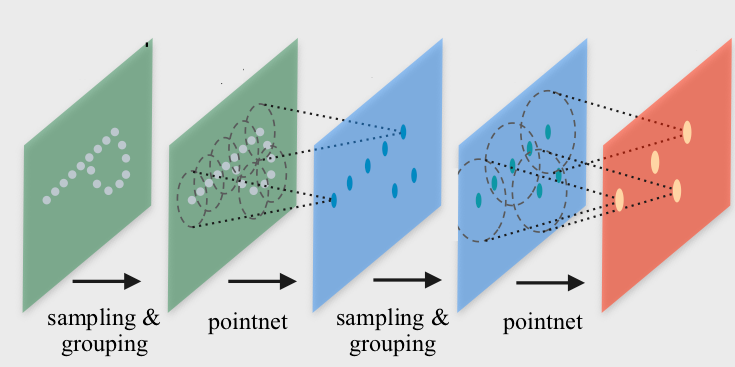

#### Phase 1: Grouping via Dynamic Graph Generation
- PyTorch Geometric provides utilities provides for dynamic graph generation via its helper package `torch_cluster`, in particular via the `knn_graph`, and `radius_graph` functions for k-nearest neighbor and ball query graph generation, respectively

# Explaining GNN Model predictions using Captum
- We demonstrate how to apply feature attribution methods to graphs. Specifically, we try to find the most important edges for each instance prediction.
- We use the Mutagenicity dataset from TUDatasets. This dataset consists of 4337 molecules graphs where the task is to predict the molecule mutagenicity.

## Loading the dataset
- We load the dataset and use 10% of the data as the test split

In [ ]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

path = '.'
dataset = TUDataset(path, name='Mutagenicity').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

In [ ]:
dataset[0]

Data(edge_index=[2, 68], x=[31, 14], edge_attr=[68, 3], y=[1])

In [ ]:
dataset

Mutagenicity(4337)

In [ ]:
len(dataset)

4337

In [ ]:
for data in train_loader:
  print(data)

DataBatch(edge_index=[2, 7958], x=[3881, 14], edge_attr=[7958, 3], y=[128], batch=[3881], ptr=[129])
DataBatch(edge_index=[2, 7912], x=[3830, 14], edge_attr=[7912, 3], y=[128], batch=[3830], ptr=[129])
DataBatch(edge_index=[2, 7962], x=[3848, 14], edge_attr=[7962, 3], y=[128], batch=[3848], ptr=[129])
DataBatch(edge_index=[2, 8050], x=[3904, 14], edge_attr=[8050, 3], y=[128], batch=[3904], ptr=[129])
DataBatch(edge_index=[2, 7660], x=[3906, 14], edge_attr=[7660, 3], y=[128], batch=[3906], ptr=[129])
DataBatch(edge_index=[2, 7776], x=[3759, 14], edge_attr=[7776, 3], y=[128], batch=[3759], ptr=[129])
DataBatch(edge_index=[2, 7354], x=[3558, 14], edge_attr=[7354, 3], y=[128], batch=[3558], ptr=[129])
DataBatch(edge_index=[2, 7660], x=[3819, 14], edge_attr=[7660, 3], y=[128], batch=[3819], ptr=[129])
DataBatch(edge_index=[2, 7924], x=[3849, 14], edge_attr=[7924, 3], y=[128], batch=[3849], ptr=[129])
DataBatch(edge_index=[2, 7546], x=[3673, 14], edge_attr=[7546, 3], y=[128], batch=[3673], p

In [ ]:
data = dataset[0]
data

Data(edge_index=[2, 68], x=[31, 14], edge_attr=[68, 3], y=[1])

### Visualizing the data
- We define some utility functions for visualizing the molecules and draw a random molecule.

In [ ]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

In [ ]:
def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()

In [ ]:
def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g


### Sample visualization
- We sample a single molecule from train_dataset and visualize it.

In [ ]:
import random

data = random.choice([t for t in train_dataset])
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

NameError: name 'plt' is not defined

In [ ]:
data

Data(edge_index=[2, 22], x=[12, 14], edge_attr=[22, 3], y=[1])

### Training the model
- We train a GNN model with 5 convoluton layers. We use GraphConv which support edge_weight as a parameter. Many convolution layers in PyTorch Geometric support this argument.

In [ ]:
import torch
from torch import nn
from torch.nn import Linear
from torch.nn import functional as F

from torch_geometric.nn import GraphConv, global_add_pool

class Net(nn.Module):
  def __init__(self, dim):
    super(Net, self).__init__()

    num_features = dataset.num_features
    self.dim = dim

    self.conv1 = GraphConv(num_features, dim)
    self.conv2 = GraphConv(dim, dim)
    self.conv3 = GraphConv(dim, dim)
    self.conv4 = GraphConv(dim, dim)
    self.conv5 = GraphConv(dim, dim)

    self.lin1 = Linear(dim, dim)
    self.lin2 = Linear(dim, dataset.num_classes)

  def forward(self, x, edge_index, batch, edge_weight=None):
    x = self.conv1(x, edge_index, edge_weight).relu()
    x = self.conv2(x, edge_index, edge_weight).relu()
    x = self.conv3(x, edge_index, edge_weight).relu()
    x = self.conv4(x, edge_index, edge_weight).relu()
    x = self.conv5(x, edge_index, edge_weight).relu()
    x = global_add_pool(x, batch)
    x = self.lin1(x).relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin2(x)
    return F.log_softmax(x, dim=-1)

In [ ]:
model = Net(dim=32)
model

Net(
  (conv1): GraphConv(14, 32)
  (conv2): GraphConv(32, 32)
  (conv3): GraphConv(32, 32)
  (conv4): GraphConv(32, 32)
  (conv5): GraphConv(32, 32)
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 2.2190e-01,  2.2999e-01,  2.2986e-01, -1.8457e-01, -1.7753e-01,
            -1.4839e-02, -2.1361e-01, -1.2664e-01,  2.5044e-01,  1.0739e-01,
            -1.4072e-01, -1.1673e-01,  1.1519e-01,  1.9162e-01],
           [ 1.2577e-01,  1.0908e-02,  4.5404e-02, -5.0812e-02,  2.1073e-01,
             8.7032e-02, -1.9393e-01,  5.2665e-02,  1.9043e-01, -1.2107e-01,
            -5.7988e-02,  2.4511e-01, -7.7449e-02, -1.5389e-02],
           [-2.1686e-01,  1.3566e-01, -2.0757e-02,  1.3819e-01,  6.5077e-02,
             4.0757e-02, -9.0414e-02,  8.1392e-02, -2.8086e-02,  8.5147e-02,
             2.5816e-01,  1.7691e-01,  1.0319e-01, -1.6415e-01],
           [ 8.6899e-02, -1.6715e-01,  1.1939e-01, -1.1016e-01,  1.4778e-01,
            -3.1428e-02, -4.9589e-03,  1.1081e-01, -2.5103e-01,  1.6272e-01,
             1.3813e-01, -1.2692e-01,  2.4319e-01, -5.2611e-02],
           [ 4.1970e-02, -4.1622e-02, -1.6076e-02,  1.9818e-01, -1.8839e-01,
            

In [ ]:
data

Data(edge_index=[2, 22], x=[12, 14], edge_attr=[22, 3], y=[1])

### Define train and test functions

In [ ]:
def train(epoch):
  model.train()

  if epoch == 51:
    for param_group in optimizer.param_groups:
      param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      output = model(data.x, data.edge_index, data.batch)
      loss = F.nll_loss(output, data.y)
      loss.backward()
      loss_all += loss.item() * data.num_graphs
      optimizer.step()
    return loss_all/len(train_dataset)

def test(loader):
  model.eval()

  correct = 0
  for data in loader:
    data = data.to(device)
    output = model(data.x, data.edge_index, data.batch)
    pred = output.max(dim=1)[1]
    correct += pred.eq(data.y).sum().item()
  return correct/len(loader.dataset)


### Train the model for 100 epochs
- The accuracy should be around 80% in the end

In [ ]:
def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
for epoch in range(1, 101):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.6696, Train Acc: 0.6596, Test Acc: 0.6536
Epoch: 002, Loss: 0.6149, Train Acc: 0.6696, Test Acc: 0.6028
Epoch: 003, Loss: 0.6025, Train Acc: 0.6960, Test Acc: 0.6467
Epoch: 004, Loss: 0.5815, Train Acc: 0.7303, Test Acc: 0.6836
Epoch: 005, Loss: 0.5572, Train Acc: 0.7398, Test Acc: 0.6882
Epoch: 006, Loss: 0.5469, Train Acc: 0.7497, Test Acc: 0.7367
Epoch: 007, Loss: 0.5228, Train Acc: 0.7690, Test Acc: 0.7506
Epoch: 008, Loss: 0.5270, Train Acc: 0.7492, Test Acc: 0.7275
Epoch: 009, Loss: 0.5188, Train Acc: 0.7836, Test Acc: 0.7552
Epoch: 010, Loss: 0.5019, Train Acc: 0.7894, Test Acc: 0.7575
Epoch: 011, Loss: 0.5015, Train Acc: 0.7751, Test Acc: 0.7506
Epoch: 012, Loss: 0.5008, Train Acc: 0.7971, Test Acc: 0.7737
Epoch: 013, Loss: 0.4837, Train Acc: 0.7907, Test Acc: 0.7667
Epoch: 014, Loss: 0.4964, Train Acc: 0.7994, Test Acc: 0.7806
Epoch: 015, Loss: 0.4764, Train Acc: 0.8081, Test Acc: 0.7898
Epoch: 016, Loss: 0.4676, Train Acc: 0.8007, Test Acc: 0.7714
Epoch: 0

## Explaining the predictions

Now we look at two popular attribution methods. First, we calculate the gradient of the output with respect to the edge weights $w_{e_i}$. Edge weights are initially one for all edges.
For the saliency method, we use the absolute value of the gradient as the attribution value for each edge:

$$
Attribution_{e_i} = |\frac{\partial F(x)}{\partial w_{e_i}}|
$$

Where $x$ is the input and $F(x)$ is the output of the GNN model on input $x$.

For Integrated Gradients method, we interpolate between the current input and a baseline input where the weight of all edges is zero and accumulate the gradient values for each edge:

$$
Attribution_{e_i} = \int_{\alpha =0}^1 \frac{\partial F(x_{\alpha)}}{\partial w_{e_i}} d\alpha
$$

Where $x_{\alpha}$ is the same as the original input graph but the weight of all edges is set to $\alpha$. Integrated Gradients complete formulation is more complicated but since our initial edge weights are equal to one and the baseline is zero, it can be simplified to the formulation above. You can read more about this method [here](https://arxiv.org/abs/1703.01365). Of course, this can not be calculated directly and is approximated by a discrete sum.

We use the [captum](https://captum.ai/) library for calculating the attribution values. We define the `model_forward` function which calculates the `batch` argument assuming that we are only explaining a single graph at a time.



In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

# Link Prediction on MovieLens
- Shows how to load a set of *.csv files as input and construct a heterogeneous graph from it. We will then use this dataset as input into a heterogenous graph model, and use it for the task of link prediction.
- Heterogenous Graph Learning:
  - A large set of real-world datasets are stored as heterogeneous graphs.
  - For example, most graphs in the area of recommendation, such as social graphs, are heterogenous, as they store information about different types of entities and their different types of relations.
  - Heterogenous graphs come with different types of information attached to nodes and edges. thus, a single node or edge feature tensor cannot hold all node or edge features of the whole graph, due to difference in type and dimensionality.
  - Example Graph:
    - https://pytorch-geometric.readthedocs.io/en/latest/_images/hg_example.svg
    - The given heterogenous graph has 1,939,743 nodes, spit between the 4 nodes types author, paper, institution and field of study. It further has 21,111,007 edges, which also are one of the 4 types: writes, affiliated with, cities, has topic.
    - The task for this graph is to infer the venue of the each paper (conference or journal) given the information stored in the graph.
- We are going to use the MoviLens dataset collected by GroupLens research group. This toy dataset describes ratings and tagging activity from MovieLens. The datatset contains approximately 100k ratings across more than 9k movies from more than 600 users. We are going to use this dataset to generate 2 nodes types holding data for movies and users, respectivity, and one edge type connecting users and movies, representing the relation of whether a user has rated a specific movie.
- The linke prediction task then tries to predict missing ratings, and can, for example, be used to recommend users new movies.

### Heterogeneous graph creation
- First, we download the dataset to an arbitary folder (in this case, the current directory),

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.9.0+cu126


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/nightly/torch-2.9.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 16.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-7ddabg_e
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-7ddabg_e
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 44dee49ad88cf5253e8092cfce3e453c00bc8c3e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.8.0-py3-none-any.whl size=1275445 sha256=d9f93dd052e9f605fba8ed35e09189a4431288b107bacca294546cdd7b636a5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gb0nb7rs/wheels/96/ab/80/5e43250505a6e639df59a3d89c6b45ed5511f70db8d0ac39c7
Successfully built torch-geometric


In [ ]:
from torch_geometric.data import download_url, extract_zip

In [ ]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Extracting ./ml-latest-small.zip


- Let's take a look at the data

In [ ]:
import pandas as pd

pd.read_csv(movies_path).head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
pd.read_csv(ratings_path).head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- We see that the `movies.csv` file provides 2 useful columns: `movieId` assigns a unique identifier to each movie, which the `genres` column represent genres of the given movie. We can make use of this column to define a feature representation that can be easily interpreted by machine learning models.

In [ ]:
# Loads the entrie movie data frame into memory
movies_df = pd.read_csv(movies_path, index_col='movieId')


In [ ]:
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [ ]:
# split genres and convert into indicator variables
genres = movies_df['genres'].str.get_dummies('|')
genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


In [ ]:
print(f'{genres.values.shape}')
genres.values

(9742, 20)


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Use genres as movie input features
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

In [ ]:
movie_feat, movie_feat.shape

(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([9742, 20]))

- The ratings.csv data connects users (as given by userId) and movies (as given by movieId). Due to simplicity, we do not make use of additional timestamp adn rating information. Here, we first read the csv file and create a mmapping that maps entry IDs to a consecutive value sin the ramge.
- Afterwards, we obtain the final `edge_index` representation of shape [2, num_ratings] from ratings.csv by merging mapped user and movies indicies with the raw indices given by the original data frame.

In [ ]:
# Load the entire ratings datafrme into memory:
ratings_df = pd.read_csv(ratings_path)
ratings_df.head(), ratings_df.shape

(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
 (100836, 4))

In [ ]:
# Create a mapping from unique user indices to range [0, num_user_nodes]
unique_user_id = ratings_df['userId'].unique()
print(f'Unique Users Count: {unique_user_id.shape[0]}, length: {len(unique_user_id)}')
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id))
})

print('Mapping of user IDs to consecutive values:')
print('==========================================')
print(unique_user_id.head())
print()

Unique Users Count: 610, length: 610
Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4



In [ ]:
# Creat a mapping from unique indices to range [0, num_movie_nodes):
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})

print("Mapping of movie IDs to consecutive values:")
print('==========================================')
print(unique_movie_id.head())

Mappin of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4


In [ ]:
# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
print('RATING USER ID')
print(ratings_user_id)
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
print(ratings_user_id)

print('===============================')
print('RATING MOVIE ID')
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
print(ratings_movie_id)
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)
print(ratings_movie_id)


RATING USER ID
        userId  mappedID
0            1         0
1            1         0
2            1         0
3            1         0
4            1         0
...        ...       ...
100831     610       609
100832     610       609
100833     610       609
100834     610       609
100835     610       609

[100836 rows x 2 columns]
tensor([  0,   0,   0,  ..., 609, 609, 609])
RATING MOVIE ID
        movieId  mappedID
0             1         0
1             3         2
2             6         5
3            47        43
4            50        46
...         ...       ...
100831   166534      9434
100832   168248      9461
100833   168250      9462
100834   168252      9463
100835   170875      9503

[100836 rows x 2 columns]
tensor([   0,    2,    5,  ..., 9462, 9463, 9503])


In [ ]:
# With this, we are ready to construct our `edge_index` in COO format
# Following PyG sematics
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print('final edge indices pointing from users to movies')
print('================================================')
print(edge_index_user_to_movie, edge_index_user_to_movie.shape)

final edge indices pointing from users to movies
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]]) torch.Size([2, 100836])


- With this, we are ready to initalize our `HeteroData` object and pass the necessary information to it. Note that we also pass in a `node_id` vector to each node type in order to reconstruct the original node indices from sampled subgraphs. We also take care of adding reverse edges to the `HeteroData` object. This allows our GNN model to use both directions of the edge for message passing.

In [ ]:
from torch_geometric.data import HeteroData
from torch_geometric import transforms as T

In [ ]:
data = HeteroData()

# Save node indicies
data['user'].node_id = torch.arange(len(unique_user_id))
data['movie'].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices
data['movie'].x = movie_feat
data['user', 'rates', 'movie'].edge_index = edge_index_user_to_movie

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be abel to pass messages in both directions.
# We can leverage the T.ToUndirected() tranfromn for this from PyG
data = T.ToUndirected()(data)

In [ ]:
print(data)

HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 100836] },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


In [ ]:
torch.arange(len(movies_df))

tensor([   0,    1,    2,  ..., 9739, 9740, 9741])

## Define Edge-level Training splits
- since our data is now read-to-be used, we can split the ratings of users into training, validation, and test splits. This is needed in order to ensure that we leak no information about edges used during evaluation into the training phase.
- For this, we make use of the `transforms.RandomLinkSplit` transformation from PyG. This transforms randomly divides the edge in the ('user', 'rating', 'movie') into training, valdiation and test edges. The `disjoint_train_ratio` parameter further separates edges in the training split into edges used for message passing `edge_index` and edges used for supervision 'edge_label_index'.
- Note, we also need to specify the reverse edge type.

In [ ]:
# For this, we first split the set of edges into
# 80% training, 10% validation, and 10% testing edges.
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1
# Negative edges during training will generated on-the-fly, so we don't want to add
# them to the graph right away.

transform = T.RandomLinkSplit(
    num_val= 0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types= ('user', 'rates', 'movie'),
    rev_edge_types=('movie', 'rev_rates', 'user')

)
train_data, val_data, test_data = transform(data)

print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 56469],
    edge_label=[24201],
    edge_label_index=[2, 24201],
  },
  (movie, rev_rates, user)={ edge_index=[2, 56469] }
)

Validation data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)


### Defining Mini-batch loaders
- We are now ready to create a mini-batch loader that will generate subgraphs that can be used as input into out GNN. While this step is not stricly neccessary for small-scale graphs, it is absolutely necessary to apply GNNs on larger graphs that do not fit onto GPU memory otherwise.
- Here, we make use of the `loader.LinkNeighborLoader` which samples multiple hops from both ends of a link and creates a subgraph from it.

In [ ]:
# In the 1st hop, we sample at most 20 neighbors
# In the 2nd hop, we sample at most 10 neighbors
# In addition, during training, we want to sample negative edges on-the-fly with a ratio of 2:1

from torch_geometric.loader import LinkNeighborLoader

# Define seed edges
edge_label_index = train_data['user', 'rates', 'movie'].edge_label_index
edge_label = train_data['user', 'rates', 'movie'].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  user={
    node_id=[606],
    n_id=[606],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[2813],
    x=[2813, 20],
    n_id=[2813],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 17818],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[17818],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7893],
    e_id=[7893],
    num_sampled_edges=[2],
  }
)


## Creating a Heterogenous Link-level GNN
- We are now ready to create our heterogenous GNN. The GNN is responsible for learning enriched node representations from the surrounding subgraphs, which can be used to derive edge-level predictions.
- For defining our heterogenous GNN, we make use of nn.SAGEConv and the nn.to_hetero() function, which transforms a GNN defined on homogenous graphs to be applied on heterogenous ones.
- In addition, we define a final-level classifier, which simply take both node embeddings of the link we are trying to predict, and applies a dot-product on them.
- As users don not have any node-level information, we choose to learn their features jointly via `torch.nn.Emedding` layer. In order to improve the expressivenss of movie features, we do the same for movie nodes, and simply add their shallow embeddings to the pre-defined genre features.

In [ ]:
from torch import nn
from torch_geometric.nn import SAGEConv, to_hetero
from torch.nn import functional as F

class GNN(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()

    self.conv1 = SAGEConv(hidden_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, hidden_channels)

  def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
    # Define a 2-layer GNN computation graph
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    return x

In [ ]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions
class Classifier(nn.Module):
  def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
    # Convert node emebddings to edge-level representations
    edge_feat_user = x_user[edge_label_index[0]]
    edge_feat_movie = x_movie[edge_label_index[1]]

    # Apply a dot-product to get a prediction per supervision edge
    return (edge_feat_user * edge_feat_movie).sum(dim=-1)

In [ ]:
class Model(nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    # Since the dataset doesnot come with rich features, we also learn 2
    # embedding matrices for users and movies
    self.movie_lin = nn.Linear(20, hidden_channels)
    self.user_emb = nn.Embedding(data['user'].num_nodes, hidden_channels)
    self.movie_emb = nn.Embedding(data['movie'].num_nodes, hidden_channels)

    # Instantiate the GNN model
    self.gnn = GNN(hidden_channels)

    # Convert GNN model into a heterogenous variant
    self.gnn = to_hetero(self.gnn, metadata=data.metadata())

    # Instantiate the final classifier
    self.classifier = Classifier()

  def forward(self, data:HeteroData) -> Tensor:
    x_dict = {
        'user': self.user_emb(data['user'].node_id),
        'movie': self.movie_lin(data['movie'].x) + self.movie_emb(data['movie'].node_id)
    }

    # `x_dict` holds feature matrices of all node types
    # `edge_index_dict` holds all edge indices of all edge types
    x_dict = self.gnn(x_dict, data.edge_index_dict)

    pred = self.classifier(
        x_dict['user'],
        x_dict['movie'],
        data['user', 'rates', 'movie'].edge_label_index
    )

    return pred

model = Model(hidden_channels=64)
print(model)




Model(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


### Training a Heterogenous Link-level GNN
- Training our GNN is then similar to training any PyTorch model. we move the model to the desired device, and intialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.
- The training loop then iterates over our mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions, and adujst models parameters via back-propagation and stochastic gradient descent.

In [ ]:
import tqdm
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 10):
  total_loss = total_examples = 0

  for sampled_data in tqdm.tqdm(train_loader):
    optimizer.zero_grad()

    sampled_data.to(device)
    pred = model(sampled_data)
    ground_truth = sampled_data['user', 'rates', 'movie'].edge_label
    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()

    total_loss += float(loss) * pred.numel()
    total_examples += pred.numel()

  print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

  0%|          | 0/190 [00:00<?, ?it/s]/tmp/ipython-input-3070712018.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_loss += float(loss) * pred.numel()
100%|██████████| 190/190 [00:02<00:00, 70.89it/s] 


Epoch: 001, Loss: 0.4232


100%|██████████| 190/190 [00:01<00:00, 121.00it/s]


Epoch: 002, Loss: 0.3378


100%|██████████| 190/190 [00:01<00:00, 122.68it/s]


Epoch: 003, Loss: 0.3133


100%|██████████| 190/190 [00:01<00:00, 116.05it/s]


Epoch: 004, Loss: 0.2965


100%|██████████| 190/190 [00:01<00:00, 120.35it/s]


Epoch: 005, Loss: 0.2821


100%|██████████| 190/190 [00:01<00:00, 125.46it/s]


Epoch: 006, Loss: 0.2703


100%|██████████| 190/190 [00:01<00:00, 120.97it/s]


Epoch: 007, Loss: 0.2608


100%|██████████| 190/190 [00:01<00:00, 122.30it/s]


Epoch: 008, Loss: 0.2539


100%|██████████| 190/190 [00:01<00:00, 126.41it/s]

Epoch: 009, Loss: 0.2432


### Evaluating a Heterogenous Link-Level GNN
- After training, we evalute our model on unseen data coming from the validation set. For this, we define a new `LinkNeighborLoader`, obtain the predictions on validation edges by running the model, and finally evalute the performance of the model by computing the AUC score over the set of predictions and their corresponding ground-truth edges

In [ ]:
# Define the validation see edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[605],
    n_id=[605],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[2698],
    x=[2698, 20],
    n_id=[2698],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 18806],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[18806],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7724],
    e_id=[7724],
    num_sampled_edges=[2],
  }
)


In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []

for sampled_data in tqdm.tqdm(val_loader):
  with torch.no_grad():
    sampled_data.to(device)
    preds.append(model(sampled_data))
    ground_truths.append(sampled_data['user', 'rates', 'movie'].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 79/79 [00:00<00:00, 186.67it/s]


Validation AUC: 0.9366
